## Introduction

The dataset used in this project was sourced from: https://www.kaggle.com/datasets/jboysen/ny-home-mortgage/data

The dataset includes over 440000 mortgage application from the state of New York in 2015. This data is publicly available as the Home Mortgage Disclosure Act (HMDA) require financial institutions to publicly disclose mortgage information.

The objective of this project is to create a model that will predict whether a mortgage application is approved or rejected.

In [49]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV, KFold
from sklearn.linear_model import LogisticRegression, LinearRegression, SGDRegressor
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier, RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.svm import LinearSVC, SVR
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import ConfusionMatrixDisplay, f1_score, make_scorer, confusion_matrix, mean_squared_error, mean_absolute_error, precision_score
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer

from xgboost import XGBClassifier, XGBRegressor
from catboost import CatBoostClassifier

from dython.nominal import associations

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

from scipy.stats import randint, uniform

### 1. Basic Data Cleaning

In [2]:
raw_data = pd.read_csv('ny_hmda_2015.csv', low_memory=False)

In [3]:
pd.set_option('display.max_columns', None)
raw_data.head()

,action_taken,action_taken_name,agency_code,agency_abbr,agency_name,applicant_ethnicity,applicant_ethnicity_name,applicant_income_000s,applicant_race_1,applicant_race_2,applicant_race_3,applicant_race_4,applicant_race_5,applicant_race_name_1,applicant_race_name_2,applicant_race_name_3,applicant_race_name_4,applicant_race_name_5,applicant_sex,applicant_sex_name,application_date_indicator,as_of_year,census_tract_number,co_applicant_ethnicity,co_applicant_ethnicity_name,co_applicant_race_1,co_applicant_race_2,co_applicant_race_3,co_applicant_race_4,co_applicant_race_5,co_applicant_race_name_1,co_applicant_race_name_2,co_applicant_race_name_3,co_applicant_race_name_4,co_applicant_race_name_5,co_applicant_sex,co_applicant_sex_name,county_code,county_name,denial_reason_1,denial_reason_2,denial_reason_3,denial_reason_name_1,denial_reason_name_2,denial_reason_name_3,edit_status,edit_status_name,hoepa_status,hoepa_status_name,lien_status,lien_status_name,loan_purpose,loan_purpose_name,loan_type,loan_type_name,msamd,msamd_name,owner_occupancy,owner_occupancy_name,preapproval,preapproval_name,property_type,property_type_name,purchaser_type,purchaser_type_name,respondent_id,sequence_number,state_code,state_abbr,state_name,hud_median_family_income,loan_amount_000s,number_of_1_to_4_family_units,number_of_owner_occupied_units,minority_population,population,rate_spread,tract_to_msamd_income
0,1,Loan originated,9,CFPB,Consumer Financial Protection Bureau,2,Not Hispanic or Latino,97.0,5,NaN,NaN,NaN,NaN,White,NaN,NaN,NaN,NaN,2,Female,0,2015,3007.0,5,No co-applicant,8,NaN,NaN,NaN,NaN,No co-applicant,NaN,NaN,NaN,NaN,5,No co-applicant,59.0,Nassau County,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,Not a HOEPA loan,1,Secured by a first lien,1,Home purchase,1,Conventional,35004.0,"Nassau County, Suffolk County - NY",1,Owner-occupied as a principal dwelling,3,Not applicable,1,One-to-four family dwelling (other than manufa...,0,Loan was not originated or was not sold in cal...,0000451965,164811,36,NY,New York,109000.0,187,363.0,1817.0,21.139999,5870.0,NaN,109.459999
1,1,Loan originated,9,CFPB,Consumer Financial Protection Bureau,2,Not Hispanic or Latino,200.0,5,NaN,NaN,NaN,NaN,White,NaN,NaN,NaN,NaN,1,Male,0,2015,111.0,5,No co-applicant,8,NaN,NaN,NaN,NaN,No co-applicant,NaN,NaN,NaN,NaN,5,No co-applicant,61.0,New York County,NaN,NaN,NaN,NaN,NaN,NaN,6.0,Quality edit failure only,2,Not a HOEPA loan,1,Secured by a first lien,1,Home purchase,1,Conventional,35614.0,"New York, Jersey City, White Plains - NY, NJ",1,Owner-occupied as a principal dwelling,3,Not applicable,1,One-to-four family dwelling (other than manufa...,6,"Commercial bank, savings bank or savings assoc...",0002735146,26589,36,NY,New York,71300.0,460,53.0,256.0,45.959999,3512.0,NaN,160.600006
2,1,Loan originated,7,HUD,Department of Housing and Urban Development,2,Not Hispanic or Latino,NaN,3,NaN,NaN,NaN,NaN,Black or African American,NaN,NaN,NaN,NaN,1,Male,0,2015,105.0,5,No co-applicant,8,NaN,NaN,NaN,NaN,No co-applicant,NaN,NaN,NaN,NaN,5,No co-applicant,71.0,Orange County,NaN,NaN,NaN,NaN,NaN,NaN,6.0,Quality edit failure only,2,Not a HOEPA loan,1,Secured by a first lien,3,Refinancing,1,Conventional,35614.0,"New York, Jersey City, White Plains - NY, NJ",1,Owner-occupied as a principal dwelling,3,Not applicable,1,One-to-four family dwelling (other than manufa...,3,Freddie Mac (FHLMC),75-2921540,141383,36,NY,New York,71300.0,296,2745.0,2586.0,38.990002,8357.0,NaN,134.820007
3,1,Loan originated,9,CFPB,Consumer Financial Protection Bureau,2,Not Hispanic or Latino,202.0,5,NaN,NaN,NaN,NaN,White,NaN,NaN,NaN,NaN,1,Male,0,2015,4064.0,2,Not Hispanic or Latino,5,NaN,NaN,NaN,NaN,White,NaN,NaN,NaN,NaN,2,Female,59.0,Nassau County,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,Not a HOEPA loan,1,Secured by a first lien,1,Home purchase,1,Conventional,35004.0,"Nassau County, Suffolk County - NY",1,Owner-occupied as a principal dwelling,3,Not applicable,1,One-to-four family dwelling (other than manufa...,0,Loan was not originated or was n

In [4]:
# Create new copy of data
data_df = raw_data.copy()

In [5]:
# Select required columns
columns_to_keep = [
    'action_taken',
    'action_taken_name',
    'applicant_ethnicity',
    'applicant_ethnicity_name',
    'applicant_income_000s',
    'applicant_race_1',
    'applicant_race_name_1',
    'applicant_sex',
    'applicant_sex_name',
    'county_code',
    'county_name',
    'hoepa_status',
    'hoepa_status_name',
    'loan_purpose',
    'loan_purpose_name',
    'loan_type',
    'loan_type_name',
    'owner_occupancy',
    'owner_occupancy_name',
    'property_type',
    'property_type_name',
    'state_abbr',
    'state_name',
    'hud_median_family_income',
    'loan_amount_000s',
]

data_df = data_df[columns_to_keep]
data_df.head()

,action_taken,action_taken_name,applicant_ethnicity,applicant_ethnicity_name,applicant_income_000s,applicant_race_1,applicant_race_name_1,applicant_sex,applicant_sex_name,county_code,county_name,hoepa_status,hoepa_status_name,loan_purpose,loan_purpose_name,loan_type,loan_type_name,owner_occupancy,owner_occupancy_name,property_type,property_type_name,state_abbr,state_name,hud_median_family_income,loan_amount_000s
0,1,Loan originated,2,Not Hispanic or Latino,97.0,5,White,2,Female,59.0,Nassau County,2,Not a HOEPA loan,1,Home purchase,1,Conventional,1,Owner-occupied as a principal dwelling,1,One-to-four family dwelling (other than manufa...,NY,New York,109000.0,187
1,1,Loan originated,2,Not Hispanic or Latino,200.0,5,White,1,Male,61.0,New York County,2,Not a HOEPA loan,1,Home purchase,1,Conventional,1,Owner-occupied as a principal dwelling,1,One-to-four family dwelling (other than manufa...,NY,New York,71300.0,460
2,1,Loan originated,2,Not Hispanic or Latino,NaN,3,Black or African American,1,Male,71.0,Orange County,2,Not a HOEPA loan,3,Refinancing,1,Conventional,1,Owner-occupied as a principal dwelling,1,One-to-four family dwelling (other than manufa...,NY,New York,71300.0,296
3,1,Loan originated,2,Not Hispanic or Latino,202.0,5,White,1,Male,59.0,Nassau County,2,Not a HOEPA loan,1,Home purchase,1,Conventional,1,Owner-occupied as a principal dwelling,1,One-to-four family dwelling (other than manufa...,NY,New York,109000.0,770
4,1,Loan originated,2,Not Hispanic or Latino,255.0,5,White,1,Male,59.0,Nassau County,2,Not a HOEPA loan,1,Home purchase,1,Conventional,1,Owner-occupied as a principal dwelling,1,One-to-four family dwelling (other than manufa...,NY,New York,109000.0,648


In [6]:
# Clean column names
def rename_columns(column_name):
    if column_name.endswith('_1'):
        return column_name[:-2]
    else:
        return column_name
    
data_df = data_df.copy().rename(columns=rename_columns)

In [7]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 439654 entries, 0 to 439653
Data columns (total 25 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   action_taken              439654 non-null  int64  
 1   action_taken_name         439654 non-null  object 
 2   applicant_ethnicity       439654 non-null  int64  
 3   applicant_ethnicity_name  439654 non-null  object 
 4   applicant_income_000s     378651 non-null  float64
 5   applicant_race            439654 non-null  int64  
 6   applicant_race_name       439654 non-null  object 
 7   applicant_sex             439654 non-null  int64  
 8   applicant_sex_name        439654 non-null  object 
 9   county_code               438462 non-null  float64
 10  county_name               438462 non-null  object 
 11  hoepa_status              439654 non-null  int64  
 12  hoepa_status_name         439654 non-null  object 
 13  loan_purpose              439654 non-null  i

In [8]:
# Replace null values categorical features
# Fill missing county values with most occuring county
data_df['county_code'] = data_df['county_code'].fillna(data_df['county_code'].mode()[0])
data_df['county_name'] = data_df['county_name'].fillna(data_df['county_name'].mode()[0])

In [9]:
# Replace null values numerical features
# Fill missing applicant income with median value for dataset
data_df['applicant_income_000s'] = data_df['applicant_income_000s'].fillna(data_df['applicant_income_000s'].median())

# Fill missing hud median family income based on county name
data_df['hud_median_family_income'] = data_df.groupby('county_name')['hud_median_family_income'].transform(lambda x: x.fillna(x.mean()))

In [10]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 439654 entries, 0 to 439653
Data columns (total 25 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   action_taken              439654 non-null  int64  
 1   action_taken_name         439654 non-null  object 
 2   applicant_ethnicity       439654 non-null  int64  
 3   applicant_ethnicity_name  439654 non-null  object 
 4   applicant_income_000s     439654 non-null  float64
 5   applicant_race            439654 non-null  int64  
 6   applicant_race_name       439654 non-null  object 
 7   applicant_sex             439654 non-null  int64  
 8   applicant_sex_name        439654 non-null  object 
 9   county_code               439654 non-null  float64
 10  county_name               439654 non-null  object 
 11  hoepa_status              439654 non-null  int64  
 12  hoepa_status_name         439654 non-null  object 
 13  loan_purpose              439654 non-null  i

In [11]:
# Check number of duplicate records
data_df.duplicated().sum()

21062

In [12]:
# Drop duplicates
data_df.drop_duplicates(inplace=True)

In [13]:
# Drop columns that end with _name ot _abbr as columns only act as descriptors
def get_name_columns(columns):
    name_columns = []
    for col in columns:
        if col.endswith('_name') or col.endswith('_abbr'):
            name_columns.append(col)
    return name_columns
        
data_df.drop(get_name_columns(data_df.columns), axis=1, inplace=True)

**Target value creation**

Action taken explanation:
1. Loan Originated
2. Application approved but not accepted 
3. Application denied by financial institution
4. Application withdrawn by applicant
5. File closed for incompleteness
6. Loan purchased by the institution
7. Preapproval request denied by financial institution

- Approved (Label 1) - 1, 2, 6 
- Denied (Label 0) - 3, 7
- Not applicable (Drop from data set) - 4, 5

In [14]:
# Add target column based on action taken values
def target_value(x):
    if x in [1, 2, 6]:
        return 1
    elif x in [3,7]:
        return 0
    else:
        return 2

data_df['target'] = data_df['action_taken'].apply(lambda x: target_value(x))

In [15]:
# Drop any rows where the target value equals 2 as not applicable
data_df = data_df[data_df['target'] != 2]

# Drop action taken column
data_df.drop('action_taken', axis=1, inplace=True)

### 2. Create Train/Test Split

In [16]:
# Create clean copy of training data
X = data_df.copy().drop(columns='target')
y = data_df['target']

# Create train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
# Compare distribution of target variable in y_train and y_test 
train_ratio = round((y_train.sum()/len(y_train))*100, 2)
test_ratio = round((y_test.sum()/len(y_test))*100, 2)

print(f'Training data target ratio: {train_ratio}')
print(f'Test data target ratio: {test_ratio}')

Training data target ratio: 78.54
Test data target ratio: 78.41


### 3. Exploratory Data Analysis and Preprocessing

In [18]:
# Create copy of data set for EDA
eda_test_data = X_train.copy()
eda_test_data['target'] = y_train

In [19]:
# Split out categorical and continuous features
categorical_columns = [
    'applicant_ethnicity',
    'applicant_race',
    'applicant_sex',
    'county_code',
    'hoepa_status',
    'loan_purpose',
    'loan_type',
    'owner_occupancy',
    'property_type',
    'target'
]

continuous_columns  = [
    'applicant_income_000s',
    'hud_median_family_income',
    'loan_amount_000s',
    'target'
]

eda_test_data_categorical = eda_test_data[categorical_columns]

eda_test_data_continuous = eda_test_data[continuous_columns]

<Axes: xlabel='loan_amount_000s', ylabel='Count'>

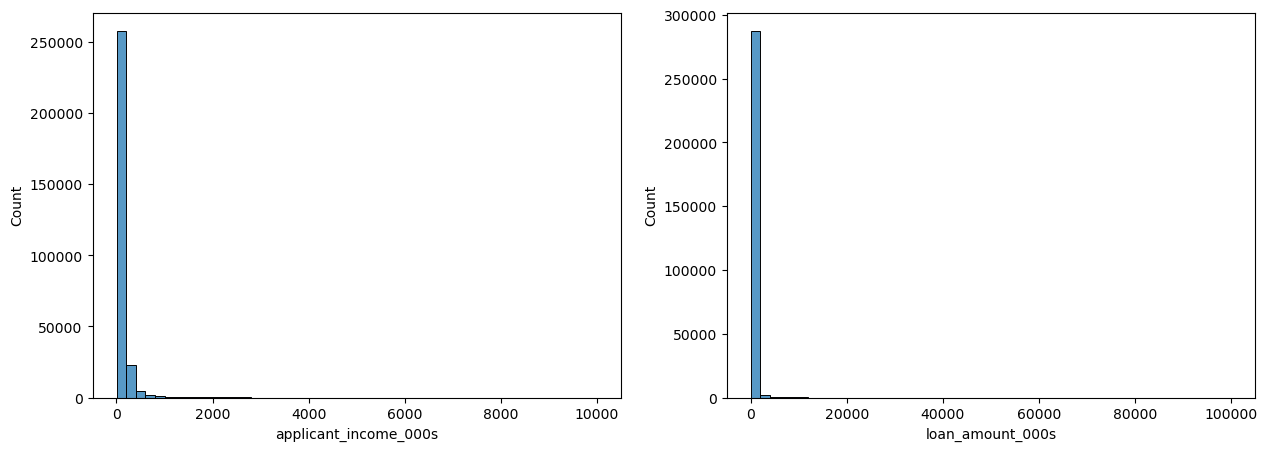

In [20]:
# Plot histograms to show distribution of income and loan amount
fig, ax = plt.subplots(1, 2, figsize=(15,5))

# Applicant Income
sns.histplot(eda_test_data['applicant_income_000s'], ax=ax[0], bins=50)

# Loan Amount
sns.histplot(eda_test_data['loan_amount_000s'], ax=ax[1], bins=50)

<Axes: xlabel='applicant_sex_mapped', ylabel='count'>

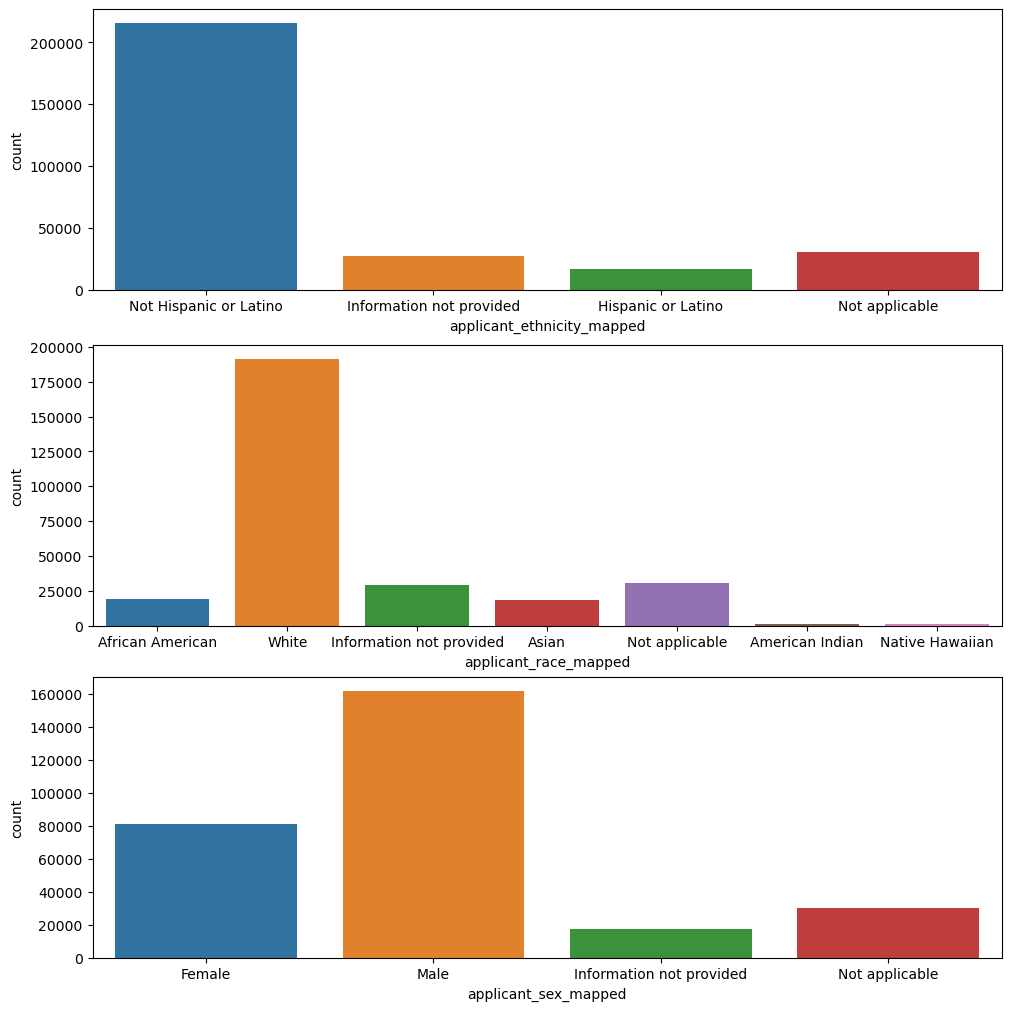

In [21]:
# Compare distribution of applicant profile variables
fig, ax = plt.subplots(3,1, figsize=(10,10), constrained_layout = True)

# Ethnicity
ethnicity_map = {
    1: "Hispanic or Latino",
    2: "Not Hispanic or Latino",
    3: "Information not provided",
    4: "Not applicable"
}
eda_test_data['applicant_ethnicity_mapped'] = eda_test_data.apply(lambda x: ethnicity_map[x['applicant_ethnicity']], axis=1) 
sns.countplot(data=eda_test_data, x='applicant_ethnicity_mapped', ax=ax[0])

# Race
race_map = {
    1: "American Indian",
    2: "Asian",
    3: "African American",
    4: "Native Hawaiian",
    5: "White",
    6: "Information not provided",
    7: "Not applicable"
}
eda_test_data['applicant_race_mapped'] = eda_test_data.apply(lambda x: race_map[x['applicant_race']], axis=1) 
sns.countplot(data=eda_test_data, x='applicant_race_mapped', ax=ax[1])

# Sex
sex_map = {
    1: "Male",
    2: "Female",
    3: "Information not provided",
    4: "Not applicable"
}
eda_test_data['applicant_sex_mapped'] = eda_test_data.apply(lambda x: sex_map[x['applicant_sex']], axis=1) 
sns.countplot(data=eda_test_data, x='applicant_sex_mapped', ax=ax[2])

<Axes: >

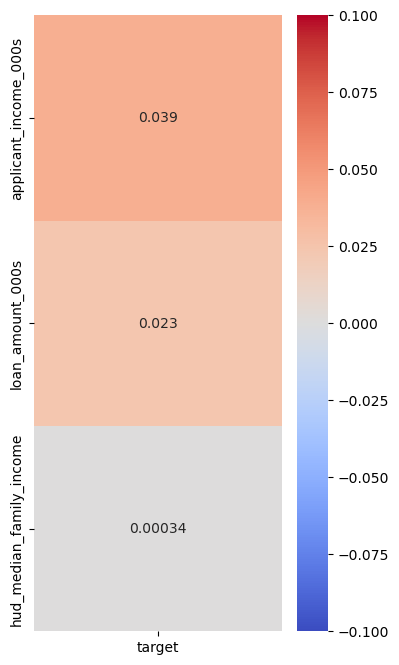

In [22]:
# Create single column heatmap plot comparing the correlation of continuous features to the target
fig, ax = plt.subplots(figsize=(4,8))

corr_matrix = eda_test_data_continuous.corr(numeric_only=True).sort_values(by='target', ascending=False)
corr_matrix_no_target = corr_matrix.drop('target')

sns.heatmap(corr_matrix_no_target[['target']], cmap='coolwarm', annot=True, vmax=0.1, vmin=-0.1)

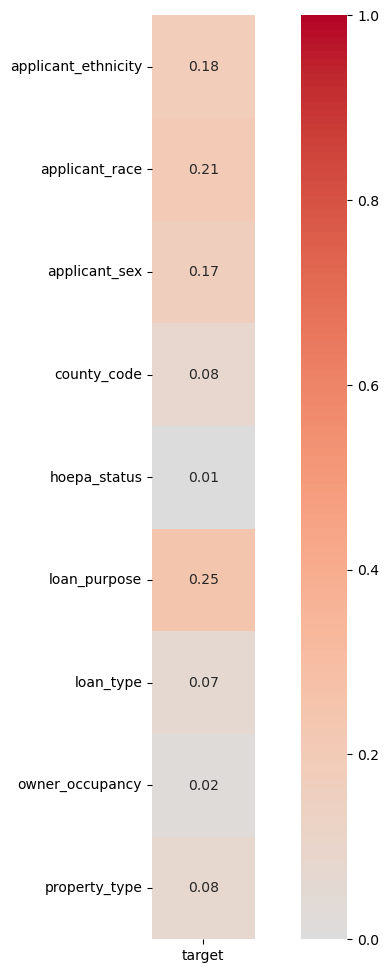

{'corr':                        target
 applicant_ethnicity  0.182935
 applicant_race       0.205017
 applicant_sex        0.171842
 county_code          0.084815
 hoepa_status         0.006195
 loan_purpose         0.249574
 loan_type            0.065445
 owner_occupancy      0.021255
 property_type        0.075361,
 'ax': <Axes: >}

In [23]:
# Plot associations of categorical features
fig, ax = plt.subplots(figsize=(12,12))
associations(eda_test_data_categorical, nominal_columns='all', display_columns='target', hide_rows='target',cmap='coolwarm', annot=True, ax=ax)

In [24]:
# Create copy of X_train data for preprocessing
X_train_raw = X_train.copy().reset_index(drop=True)

# Drop columns that have insignicant correlation / association to the target variable
cols_to_drop = [
    'hud_median_family_income',
    'hoepa_status',
    'owner_occupancy'
]

X_train_raw.drop(columns=cols_to_drop, axis=1, inplace=True)

In [25]:
# Define one-hot features
categorical_columns_onehot = [
    'applicant_ethnicity', 
    'applicant_race', 
    'applicant_sex', 
    'county_code', 
    'loan_purpose', 
    'loan_type',
    'property_type'
]

In [26]:
# Define one-hot encoder
oh_encoder = OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False)

# One-hot encoding
oh_encoded = oh_encoder.fit_transform(X_train_raw[categorical_columns_onehot])

# Create dfs for encoded arrays
oh_encoded_df = pd.DataFrame(oh_encoded)
oh_encoded_df.columns = oh_encoder.get_feature_names_out()

In [27]:
# Join continuous and categorical dataframes
X_train_cleaned = pd.concat([X_train_raw, oh_encoded_df], axis=1)
X_train_cleaned.head()

,applicant_ethnicity,applicant_income_000s,applicant_race,applicant_sex,county_code,loan_purpose,loan_type,property_type,loan_amount_000s,applicant_ethnicity_2,applicant_ethnicity_3,applicant_ethnicity_4,applicant_race_2,applicant_race_3,applicant_race_4,applicant_race_5,applicant_race_6,applicant_race_7,applicant_sex_2,applicant_sex_3,applicant_sex_4,county_code_3.0,county_code_5.0,county_code_7.0,county_code_9.0,county_code_11.0,county_code_13.0,county_code_15.0,county_code_17.0,county_code_19.0,county_code_21.0,county_code_23.0,county_code_25.0,county_code_27.0,county_code_29.0,county_code_31.0,county_code_33.0,county_code_35.0,county_code_37.0,county_code_39.0,county_code_41.0,county_code_43.0,county_code_45.0,county_code_47.0,county_code_49.0,county_code_51.0,county_code_53.0,county_code_55.0,county_code_57.0,county_code_59.0,county_code_61.0,county_code_63.0,county_code_65.0,county_code_67.0,county_code_69.0,county_code_71.0,county_code_73.0,county_code_75.0,county_code_77.0,county_code_79.0,county_code_81.0,county_code_83.0,county_code_85.0,county_code_87.0,county_code_89.0,county_code_91.0,county_code_93.0,county_code_95.0,county_code_97.0,county_code_99.0,county_code_101.0,county_code_103.0,county_code_105.0,county_code_107.0,county_code_109.0,county_code_111.0,county_code_113.0,county_code_115.0,county_code_117.0,county_code_119.0,county_code_121.0,county_code_123.0,loan_purpose_2,loan_purpose_3,loan_type_2,loan_type_3,loan_type_4,property_type_2,property_type_3
0,2,44.0,3,2,47.0,2,1,1,210,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,3,133.0,5,1,27.0,3,1,1,265,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,2,26.0,5,2,29.0,2,1,1,2,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2,141.0,5,1,47.0,1,1,1,637,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3,38.0,6,3,85.0,3,1,1,216,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [28]:
# Drop columns that have been encoded
X_train_cleaned.drop(columns=categorical_columns_onehot, axis=1, inplace=True)

In [29]:
# Reset y train index so x and y match
y_train.reset_index(drop=True, inplace=True)

### 4. Model Selection

In [30]:
# Define the classifiers to test
clfs = [
    ('Logistic Regression', LogisticRegression(solver='liblinear', max_iter=2000)),
    ('Decision Tree', DecisionTreeClassifier()),
    ('Random Forest', RandomForestClassifier(random_state=42)),
    ('Linear SVM', LinearSVC(random_state=42, max_iter=1000, dual='auto')),
    ('XGBoost', XGBClassifier(random_state=42)),
    ('AdaBoost', AdaBoostClassifier(random_state=42, algorithm='SAMME')),
    ('Gradient Boost', GradientBoostingClassifier(random_state=42)),
    ('Bagging', BaggingClassifier(random_state=42)),
    ('CatBoost', CatBoostClassifier(random_state=42, verbose=0)),
]

In [31]:
# Create KFold object with 10 folds
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Set F1 as evaluation metric
scorer = make_scorer(f1_score, average='weighted')

# Dictionary to store results
results = {}

# Evaluate each classifier using cross-validation
for clf_name, clf in clfs:
    cv_scores = cross_val_score(clf, X_train_cleaned, y_train, cv=kf, scoring=scorer)
    results[clf_name] = cv_scores

cv_scores_df = pd.DataFrame(results)

<Axes: >

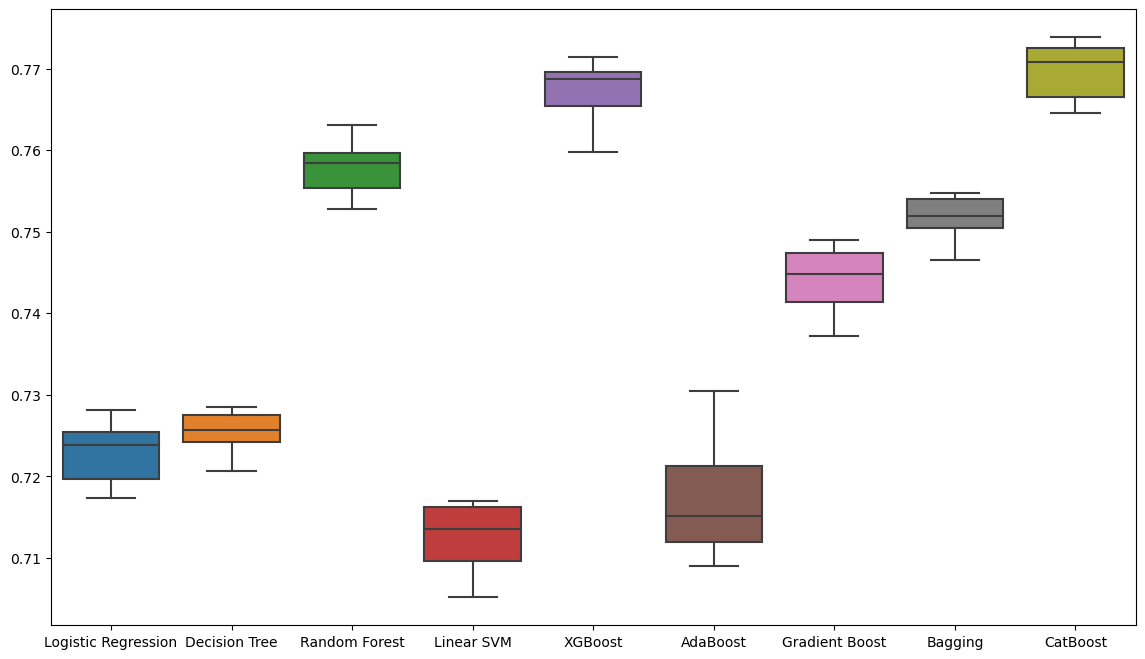

In [32]:
# Plot scores of each test
fig, ax = plt.subplots(figsize=(14, 8))
sns.boxplot(cv_scores_df)

### 5. Feature Engineering

Earlier EDA showed a right skew in both applicant income and loan amount, by implementing a log transformation we can test if it improves the acccuracy of the model

In [33]:
skewed_features = ['applicant_income_000s', 'loan_amount_000s']

# Define function to apply log transform
def log_of_feature(data_df, skewed_features):
    data = data_df.copy()
    for feature in skewed_features:
        data[feature] = np.sqrt(data[feature])
    return data

# Apply the function to X_train
X_train_cleaned_log = log_of_feature(X_train_cleaned, skewed_features)

<Axes: xlabel='loan_amount_000s', ylabel='Count'>

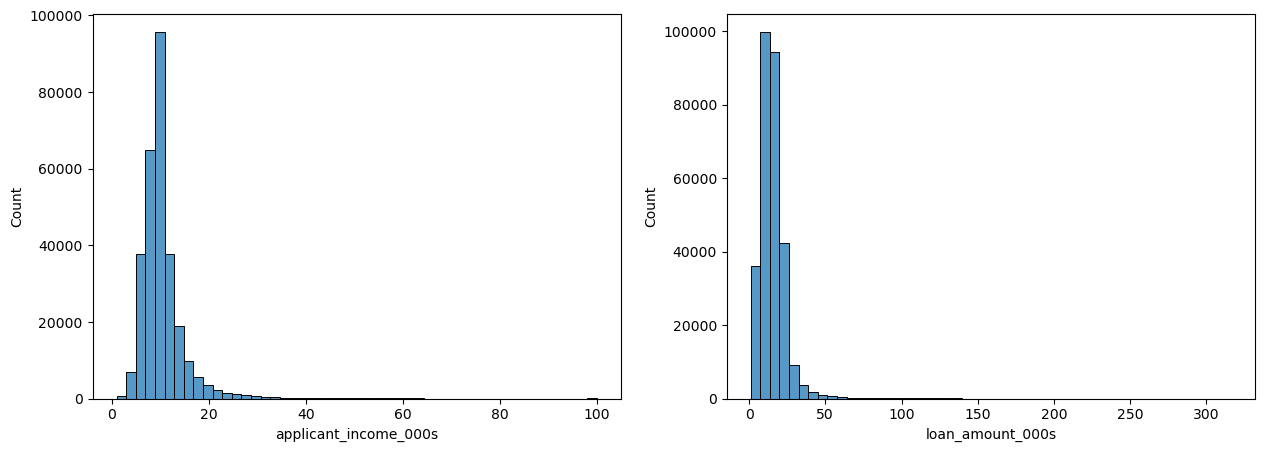

In [34]:
# Plot histograms to show distribution of income and loan amount
fig, ax = plt.subplots(1, 2, figsize=(15,5))

# Applicant Income
sns.histplot(X_train_cleaned_log['applicant_income_000s'], ax=ax[0], bins=50)

# Loan Amount
sns.histplot(X_train_cleaned_log['loan_amount_000s'], ax=ax[1], bins=50)

In [35]:
# Choosing to use the XGBoost Classifier as it scored second best to the CatBoost classifier but is quicker to optimise
xgb_boost_clf = XGBClassifier(random_state=42)

cv_scores = cross_val_score(xgb_boost_clf, X_train_cleaned, y_train, cv=kf, scoring=scorer)
cv_scores_log = cross_val_score(xgb_boost_clf, X_train_cleaned_log, y_train, cv=kf, scoring=scorer)

print(f'CV score without log transform: {cv_scores.mean()}')
print(f'CV score with log transform: {cv_scores_log.mean()}')

CV score without log transform: 0.767373274006583
CV score with log transform: 0.767373274006583


Log transformation has no impact

In [36]:
# Test if feature scaling impacts model performance

# Define function to scale features
def scale_features(data, features):
    data = data.copy()
    scaler = StandardScaler()
    scaler.fit(data[features])
    data[features] = scaler.transform(data[features])
    return data

# Apply scaler function
X_train_cleaned_scaled = scale_features(X_train_cleaned, skewed_features)

In [37]:
xgb_boost_clf = XGBClassifier(random_state=42)

cv_scores = cross_val_score(xgb_boost_clf, X_train_cleaned, y_train, cv=kf, scoring=scorer)
cv_scores_scaled = cross_val_score(xgb_boost_clf, X_train_cleaned_scaled, y_train, cv=kf, scoring=scorer)

print(f'CV score without log transform: {cv_scores.mean()}')
print(f'CV score with log transform: {cv_scores_scaled.mean()}')

CV score without log transform: 0.767373274006583
CV score with log transform: 0.767373274006583


Feature scaling has no impact

### 6. Pipeline

In [38]:
# Create custom transformer to drop columns 
class DropColumns(BaseEstimator, TransformerMixin):
    def __init__(self, cols_to_drop):
        self.cols_to_drop = cols_to_drop
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        return X.drop(self.cols_to_drop, axis=1)
    def get_feature_names(self, input_features=None):
        return None
    
# Create custom transformer to convert category
class ConvertToCategory(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X_copy = X.copy()
        for col in self.columns:
            X_copy[col] = X_copy[col].astype('category')
        return X_copy
    def get_feature_names(self, input_features=None):
        return input_features

In [39]:
# Define drop columns pipeline
drop_columns_pipeline = Pipeline([
    ('drop_columns', DropColumns(cols_to_drop))
])

# Define one-hot encoding pipeline
oh_encoder_pipeline = Pipeline([
    ('convert_to_category', ConvertToCategory(categorical_columns_onehot)),
    ('oh_encoder', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False))
])

# Define preprocessing pipeline
preprocess_pipeline = ColumnTransformer([
        ('drop_columns', drop_columns_pipeline, cols_to_drop),
        ('oh_encoder', oh_encoder_pipeline, categorical_columns_onehot)
    ], remainder='passthrough')

In [40]:
X_train_processed = preprocess_pipeline.fit_transform(X_train)

### 7. Hyperparameter Tuning

In [41]:
# Define the parameter grid for XGBoost
xgb_param_grid = {
    'n_estimators': randint(low=50, high=300),
    'learning_rate':uniform(0.1, 0.39),
    'max_depth': randint(low=5, high = 25),
    'subsample': uniform(0, 1),
    'colsample_bytree': uniform(0, 1),
    'min_child_weight': randint(low=0, high= 20),
    'reg_alpha': randint(low=0, high=100),
    'reg_lambda':randint(low=0, high=10),
    'gamma': uniform(0, 1),
}

# Initialize the XGBClassifier
xgb_model = XGBClassifier(random_state=42, eval_metric='error')

# Set up RandomizedSearchCV with F1 score as the evaluation metric
scorer = make_scorer(f1_score, average='weighted')
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=xgb_param_grid,
    n_iter=10,  
    scoring=scorer,
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

In [42]:
# Fit the model using RandomizedSearchCV
random_search.fit(X_train_processed, y_train)

# Print the best parameters and the best score
print("Best parameters found: ", random_search.best_params_)
print("Best cross-validation score: ", random_search.best_score_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters found:  {'colsample_bytree': 0.8331949117361643, 'gamma': 0.17336465350777208, 'learning_rate': 0.2525136369535639, 'max_depth': 22, 'min_child_weight': 7, 'n_estimators': 181, 'reg_alpha': 1, 'reg_lambda': 5, 'subsample': 0.20794166286818883}
Best cross-validation score:  0.7702212590511894


In [43]:
# Define the parameter grid with expanded ranges
xgb_param_grid_grid_search = {
    'n_estimators': [160, 165, 175],
    'max_depth': [13, 14, 15],
    'learning_rate': [0.3, 0.35, 0.4],
    'subsample': [0.65, 0.7, 0.75],
    'colsample_bytree': [0.55, 0.6, 0.65],
    'gamma': [0.3, 0.35, 0.4],
    'min_child_weight': [1],
    'reg_alpha': [6],
    'reg_lambda': [3],
}

# Initialize the XGBClassifier
xgb_model = XGBClassifier(random_state=42, eval_metric='error')

# Set up RandomizedSearchCV with F1 score as the evaluation metric
scorer = make_scorer(f1_score, average='weighted')
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=xgb_param_grid_grid_search,
    scoring=scorer,
    cv=5,
    verbose=1,
    n_jobs=-1
)

In [44]:
# Fit the model using RandomizedSearchCV
grid_search.fit(X_train_processed, y_train)

# Print the best parameters and the best score
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score: ", grid_search.best_score_)

Fitting 5 folds for each of 729 candidates, totalling 3645 fits
Best parameters found:  {'colsample_bytree': 0.65, 'gamma': 0.35, 'learning_rate': 0.4, 'max_depth': 15, 'min_child_weight': 1, 'n_estimators': 160, 'reg_alpha': 6, 'reg_lambda': 3, 'subsample': 0.7}
Best cross-validation score:  0.7741358435984066


In [45]:
print(f'XGBoost model score (default hyperparameters): {cv_scores.mean()}')
print(f'XGBoost model score (tuned hyperparamters: {grid_search.best_score_}')

XGBoost model score (default hyperparameters): 0.767373274006583
XGBoost model score (tuned hyperparamters: 0.7741358435984066


### 8. Model Evaluation

In [46]:
# Transform test data using pipeline
X_test_processed = preprocess_pipeline.transform(X_test)

xgb_boost = XGBClassifier(random_state=42)

# Predict Y test values
y_pred = grid_search.best_estimator_.predict(X_test_processed)

In [47]:
f1_score(y_test, y_pred, average='weighted')

0.7754203488196387

In [50]:
precision_score(y_test, y_pred)

0.8266045943677021

Text(0.5, 1.0, 'Confusion Matrix on Training Data')

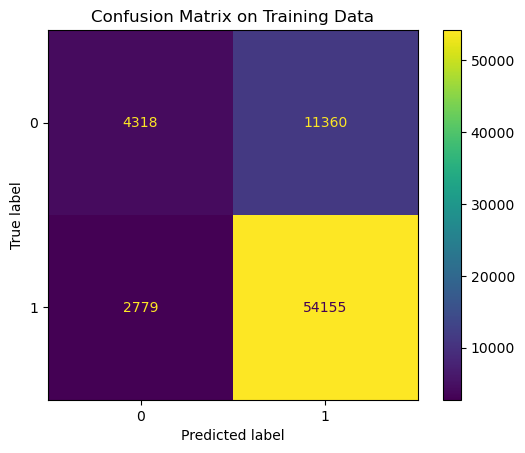

In [48]:
# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title('Confusion Matrix on Training Data')